In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [168]:
import os
from pathlib import Path

def clean_percents(item):
    if '%' in str(item):
        item = item.replace('%', '')
        return float(item) / 100
    return item

def create_census_df():
    '''
    Reads census files for every year and concatenates the desired info into a single dataframe
    '''
    paths = sorted(Path('census_info').iterdir(), key=os.path.getmtime)
    data = []
    year = 2010
    for path in paths:
        if os.path.basename(path).endswith('.csv'):
            census = pd.read_csv(path).dropna()[:-1]
            census['Year'] = year
            census.columns = census.columns.str.replace('!!', ' ')
            if year < 2015:
                census['United States Total Estimate'] = census['United States Total Estimate'].apply(clean_percents)
            else:
                census['United States Percent Estimate'] = census['United States Percent Estimate'].apply(clean_percents)
            group_1824 = census.iloc[1:5]
            group_1824['Metric'] = 'Educational Attainment: 18-24'
            data.append(group_1824)
            group_o25 = census.iloc[6:13]
            group_o25['Metric'] = 'Educational Attainment: 25 and Over'
            data.append(group_o25)
            group_poverty = census.iloc[-9:-5]
            group_poverty['Metric'] = 'Poverty Rate'
            data.append(group_poverty)
            group_earnings = census.tail()
            group_earnings['Metric'] = 'Median Earnings'
            data.append(group_earnings)
            year += 1
    
    census_df = pd.concat(data)
    census_df['Label'] = census_df['Label'].apply(str.strip)
    census_df = census_df.set_index('Year')
    return census_df

census_data = create_census_df()

In [169]:
def some_college_1824(frame):
    '''
    A function used in conjunction with .apply() to returns a series of the total percentage of Americans
    aged 18-24 that have attained at least some college per year
    '''
    year = frame.index[0]
    edu_at = frame[frame['Metric'] == 'Educational Attainment: 18-24']
    if year < 2015:
        some_col = edu_at[edu_at['Label'] == 'Some college or associate\'s degree']['United States Total Estimate'][year]
        higher_col = edu_at[edu_at['Label'] == 'Bachelor\'s degree or higher']['United States Total Estimate'][year]
    else:
        some_col = edu_at[edu_at['Label'] == 'Some college or associate\'s degree']['United States Percent Estimate'][year]
        higher_col = edu_at[edu_at['Label'] == 'Bachelor\'s degree or higher']['United States Percent Estimate'][year]
    return some_col + higher_col

college_1824 = census_data.groupby('Year').apply(some_college_1824)

In [170]:
def convert_to_int(item):
    '''
    Takes a string representation of a number with commas and converts it to a numpy integer
    '''
    return np.int64(item.replace(',', ''))

def get_median_yearly(frame):
    '''
    A function used in conjunction with .apply() to returns a series of the total percentage of Americans
    aged 18-24 that have attained at least some college per year
    '''
    year = frame.index[0]
    median = frame[frame['Metric'] == 'Median Earnings']
    median['United States Total Estimate'] = median['United States Total Estimate'].apply(convert_to_int)
    return median['United States Total Estimate'].mean()

            
median_yearly = census_data.groupby('Year').apply(get_median_yearly)

In [173]:
def get_college_poverty_rate(frame):
    '''
    A function used in conjunction with .apply() to returns a series of the poverty rate for Americans with
    at least some college by year
    '''
    year = frame.index[0]
    poverty = frame[frame['Metric'] == 'Poverty Rate']
    if year < 2015:
        some_col = poverty[poverty['Label'] == 'Some college or associate\'s degree']['United States Total Estimate'][year]
        higher_col = poverty[poverty['Label'] == 'Bachelor\'s degree or higher']['United States Total Estimate'][year]
    else:
        some_col = poverty[poverty['Label'] == 'Some college or associate\'s degree']['United States Percent Estimate'][year]
        higher_col = poverty[poverty['Label'] == 'Bachelor\'s degree or higher']['United States Percent Estimate'][year]
    return some_col + higher_col
            
college_poverty_rate = census_data.groupby('Year').apply(get_college_poverty_rate)

In [118]:
def create_ap_volume_df():
    '''
    Reads a csv file containing AP Exam volume change data and returns a series containing the total volume of
    AP exams for each year, 2010-2020
    '''
    ap_volume = pd.read_excel(r'ap_info/AP-Exam-Volume-Changes-2010-2020.xls', header=1)[:88].set_index('   SUBJECT ')
    tot_volume = ap_volume.loc['   TOTAL ']
    tot_volume = tot_volume[(tot_volume.index != '%\nChange')]
    for i in range(1, 10):
        tot_volume = tot_volume[(tot_volume.index != f'%\nChange.{i}')]
    return tot_volume

volume_data = create_ap_volume_df()

In [119]:
def get_school_data():
    '''
    Reads a csv file containing data for the number of schools offering AP exams from 2011-2020 and returns a tuple of two
    series: 1. The total number of schools offering AP exams, 2. The average number of AP subjects per participating school
    '''
    ap_schools = pd.read_excel(r'ap_info/Number-of-Schools-Offering-AP-Exams-2011-2020.xls', header=1)[1:43].set_index('SUBJECT')
    ap_schools.columns = ap_schools.columns.astype(str)
    ap_schools = ap_schools.loc[:, :'2020']
    total_schools = ap_schools.loc['TOTAL SCHOOLS'].drop('%')
    total_subjects = ap_schools.loc['Subjects Per School'].drop('%')
    for i in range(1, 9):
        total_schools = total_schools.drop(f'%.{i}')
        total_subjects = total_subjects.drop(f'%.{i}')
    return (total_schools, total_subjects)

total_schools, total_subjects = get_school_data()

In [ ]:
# I HAVE:
# college_1824, median_yearly, college_poverty_rate, volume_data, total_schools, total_subjects

In [175]:
def get_regression_line(series1, series2):
    combined = np.array([series1, series2])
    return stats.linregress(combined)

In [184]:
get_regression_line(median_yearly, college_1824)

LinregressResult(slope=-6.702562392206316e-07, intercept=0.5792727867661596, rvalue=-0.1631117229177516, pvalue=0.6525355291138957, stderr=1.4333595867696523e-06)

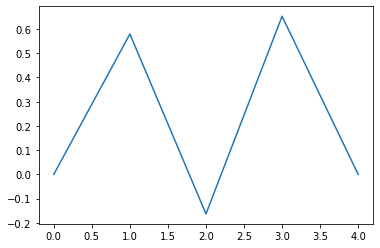

In [186]:
import matplotlib.pyplot as plt

plt.plot(get_regression_line(median_yearly, college_1824))
plt.show()

In [174]:
import scipy.stats as stats

stats.ttest_ind(total_schools, total_subjects)

Ttest_indResult(statistic=37.12985794332884, pvalue=1.8303713677451723e-18)

In [18]:
stats.ttest_ind(total_schools, tot_volume, equal_var=False)

Ttest_indResult(statistic=-21.296709839735154, pvalue=1.1600058680738558e-09)

In [19]:
stats.pearsonr(total_schools, total_subjects)

(0.696887622916357, 0.025121097774432322)

In [21]:
total_schools.corr(total_subjects)

0.696887622916357

In [22]:
schools_subjects = np.array([total_schools, total_subjects])

In [23]:
stats.linregress(schools_subjects)

LinregressResult(slope=0.00012884273000304312, intercept=6.43975161565699, rvalue=0.696887622916357, pvalue=0.02512109777443229, stderr=4.687923863995436e-05)

In [36]:
tot_volume[1:].apply(lambda x: x.astype(np.float)).corr(total_schools)

nan

In [34]:
tot_volume[1:].apply(lambda x: x.astype(np.float))

2011    3456020.0
2012    3698407.0
2013    3938100.0
2014    4176200.0
2015    4478936.0
2016    4704980.0
2017    4957931.0
2018    5090324.0
2019    5098815.0
2020    4751957.0
Name:    TOTAL , dtype: float64

In [28]:
total_schools

2011    18340.0
2012    18647.0
2013    18920.0
2014    19493.0
2015    21594.0
2016    21953.0
2017    22169.0
2018    22612.0
2019    22678.0
2020    22152.0
Name: TOTAL SCHOOLS, dtype: float64

In [37]:
stats.pearsonr(tot_volume[1:].apply(lambda x: x.astype(np.float)), total_schools)

(0.9747842739826725, 1.7157800828967895e-06)

In [128]:
stats.pearsonr(volume_data[:-1], college_1824)

(0.55588353870428, 0.09521510894452553)